# Bibliographie des models de diffusion

## Le bass model

Il s'agit de l'un des premiers modèles de diffusion. Il ne capture pas le reseau entre les individus mais il incorpore l'imitation. Ce modèle se réalise à temps discré. A chaque nouvelle periode t le nombre d'infécté,F(t) grandi de p(1-F(t-1)) correspondant aux individus infecté spontanément et q(1_F(t-1))F(t-1) qui correspond aux individus ayant était contaminé par d'autres individus infectés.
Le nombre d'infecté grand lentement au debut de ce model mais finit par explosé rapidement, puis le nombre d'infécté ralenti car il n'y plus beaucoup d'individu sain à infecter.

## SIR

Le model SIR prend en compte les réseaux. Il y a trois type de noeud: Susceptible qui correspond au individus sains pas encore contaminés. Infecté, pour ceux qui ont la maladie et qui peuvent la transmettre à leurs voisins et enfin les "removed" qui sont ceux qui sont mort ou bien soigné, ils sont alors considérés comme des noeuds immunisés et ne peuvent plus tranmettre la maladie à leurs voisins. C'est un bon modèle de diffusion pour les maladies.

## SIS

Comme le model SIR le model SIS prend les réseaux mais à la différence de ce dernier, les individus infectés peuvent guérir et etre infectieux à nouveaux. La propagation y est donc plus rapide.

# Choix du meilleur modèle

In [18]:
import datetime
import os
import yaml

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [11]:
# Lecture du fichier d'environnement
ENV_FILE = '../env.yaml'
with open(ENV_FILE) as f:
    params = yaml.load(f) #, Loader=yaml.FullLoader)

# Initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE = os.path.join(ROOT_DIR,
                         params['directories']['processed'],
                         params['files']['all_data'])

# Lecture du fichier de données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=['Last Update'])
               .assign(day=lambda _df: _df['Last Update'].dt.date)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df['day'] <= datetime.date(2020, 3, 12)]
              )

C:\Users\beauj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


## Modèle SIS

In [4]:
def SIS(t, y):
    S = y[0]
    I = y[1]
    return([I*gamma-beta*S*I, beta*S*I-gamma*I,])

In [32]:
korea_df = (epidemie_df[epidemie_df['Country/Region'] == 'South Korea']
             .groupby(['Country/Region', 'day'])
             .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
             .reset_index()
            )
korea_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
38,South Korea,2020-03-05,6088.0,35.0,41.0
39,South Korea,2020-03-06,6593.0,42.0,135.0
40,South Korea,2020-03-07,7041.0,44.0,135.0
41,South Korea,2020-03-08,7314.0,50.0,118.0
42,South Korea,2020-03-09,7478.0,53.0,118.0


In [33]:
beta, gamma = [0.1, 0.2]
solution_korea = solve_ivp(SIS, [0,len(korea_df)-1], [51_470_000, 1], t_eval=np.arange(0, 40, 1))

KeyboardInterrupt: 

In [ ]:
plt.plot(solution_korea.y[1], label='S.Korea infected')
plt.plot(korea_df['Confirmed'], label='S.Korea confirmed')
plt.plot(solution_korea.y[0], label='S.Korea susceptible')
plt.legend()
plt.show()

La boucle met beaucoup trop longtemps pour faire tourner ce code

## Bass Model

formule: f(x) = f(x-1) + p(1-f(x-1))+q(1-f(x-1))f(x-1)

In [96]:
infected = [0,1]
while len(infected)<= len(korea_df)-1:
    infected.append(round(infected[len(infected)-1]+0.00000001*(51470000-infected[len(infected)-1])
                    +0.000000004*(51470000-infected[len(infected)-1])*infected[len(infected)-1],0))

In [97]:
print(infected)

[0, 1, 2.0, 3.0, 4.0, 5.0, 7.0, 9.0, 11.0, 14.0, 17.0, 21.0, 26.0, 32.0, 39.0, 48.0, 58.0, 70.0, 85.0, 103.0, 125.0, 151.0, 183.0, 221.0, 267.0, 322.0, 389.0, 470.0, 567.0, 684.0, 825.0, 995.0, 1200.0, 1448.0, 1747.0, 2107.0, 2541.0, 3065.0, 3696.0, 4457.0, 5375.0, 6482.0, 7817.0]


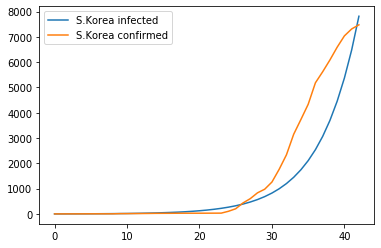

In [98]:
plt.plot(infected, label='S.Korea infected')
plt.plot(korea_df['Confirmed'], label='S.Korea confirmed')
plt.legend()
plt.show()

On observe que calibrer ainsi, notre modèle suit plutot bien la tendance mais la suite laisse à presager que le nombre d'infecté prévu risque d'exploser alors que la croissance du nombre de réel d'infectés semble ralentir.
Aucun de ces modèles ne semble repésenter serieusement la propagation du corona virus. Sur le papier cependant le SIR semble le plus adapté à la situation mais pour marcher de manière optimum il nous faudrait connaitre les lien entre les individus pour connaitre de quelle manière le virus ce propage.